In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

##############################################################################################################################

## Time series forecasting as supervised learning

Pandas df.shift function is very useful for converting the time series data into supervised learning data, it basically creates a copy of the selected column and shifts the values in that column according to the no.of periods given.

In [3]:
df = pd.DataFrame()
df['t'] = [x for x in range(10)]
df['t-1'] = df['t'].shift(1)
print(df)

   t  t-1
0  0  NaN
1  1  0.0
2  2  1.0
3  3  2.0
4  4  3.0
5  5  4.0
6  6  5.0
7  7  6.0
8  8  7.0
9  9  8.0


In [4]:
df = pd.DataFrame()
df['t'] = [x for x in range(10)]
df['t+1'] = df['t'].shift(-1)
print(df)

   t  t+1
0  0  1.0
1  1  2.0
2  2  3.0
3  3  4.0
4  4  5.0
5  5  6.0
6  6  7.0
7  7  8.0
8  8  9.0
9  9  NaN


**This permits not only classical X -> y prediction, but also X -> Y where both input and output can be sequences**

Further, the shift function also works on so-called multivariate time series problems. That is where instead of having one set of observations for a time series, we have multiple (e.g. temperature and pressure). All variates in the time series can be shifted forward or backward to create multivariate input and output sequences.

**series_to_supervised** function :- 

The function takes four arguments:

    data: Sequence of observations as a list or 2D NumPy array. Required.
    n_in: Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1.
    n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.
    dropnan: Boolean whether or not to drop rows with NaN values. Optional. Defaults to True.

The function returns a single value:

    return: Pandas DataFrame of series framed for supervised learning.


In [5]:
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [6]:
values = [x for x in range(10)]
# data = series_to_supervised(values)
data = series_to_supervised(values, 3)
print(data)

   var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
3        0.0        1.0        2.0        3
4        1.0        2.0        3.0        4
5        2.0        3.0        4.0        5
6        3.0        4.0        5.0        6
7        4.0        5.0        6.0        7
8        5.0        6.0        7.0        8
9        6.0        7.0        8.0        9


In [7]:
# a forecast problem with an input sequence of 2 past observations to forecast 2 future observations as follows:

values = [x for x in range(10)]
data = series_to_supervised(values, n_in=2, n_out=2)
print(data)

   var1(t-2)  var1(t-1)  var1(t)  var1(t+1)
2        0.0        1.0        2        3.0
3        1.0        2.0        3        4.0
4        2.0        3.0        4        5.0
5        3.0        4.0        5        6.0
6        4.0        5.0        6        7.0
7        5.0        6.0        7        8.0
8        6.0        7.0        8        9.0


**Multivariate Forecasting**

Another important type of time series is called multivariate time series.

This is where we may have observations of multiple different measures and an interest in forecasting one or more of them.

In [8]:
raw = pd.DataFrame()
raw['ob1'] = [x for x in range(10)]
raw['ob2'] = [x for x in range(50, 60)]
values = raw.values
data = series_to_supervised(values)
print(data)

   var1(t-1)  var2(t-1)  var1(t)  var2(t)
1        0.0       50.0        1       51
2        1.0       51.0        2       52
3        2.0       52.0        3       53
4        3.0       53.0        4       54
5        4.0       54.0        5       55
6        5.0       55.0        6       56
7        6.0       56.0        7       57
8        7.0       57.0        8       58
9        8.0       58.0        9       59


###############################################################################################################################

In [9]:
df = pd.read_csv("C:\\Users\\srevaatsav\\Downloads\\air pollution data\\LSTM-Multivariate_pollution.csv")

In [10]:
df

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [11]:
df["wnd_dir"].unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [12]:
# y = df["pollution"]
# del df["pollution"]

In [13]:
def func(s):
    if s == "SE":
        return 1
    elif s == "NE":
        return 2
    elif s == "NW":
        return 3
    else:
        return 4

df["wind_dir"] = df["wnd_dir"].apply(func)

In [14]:
del df["wnd_dir"]

In [15]:
df

,date,pollution,dew,temp,press,wnd_spd,snow,rain,wind_dir
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,1
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,1
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,1
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,1
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,1
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,3
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,3
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,3
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,246.72,0,0,3


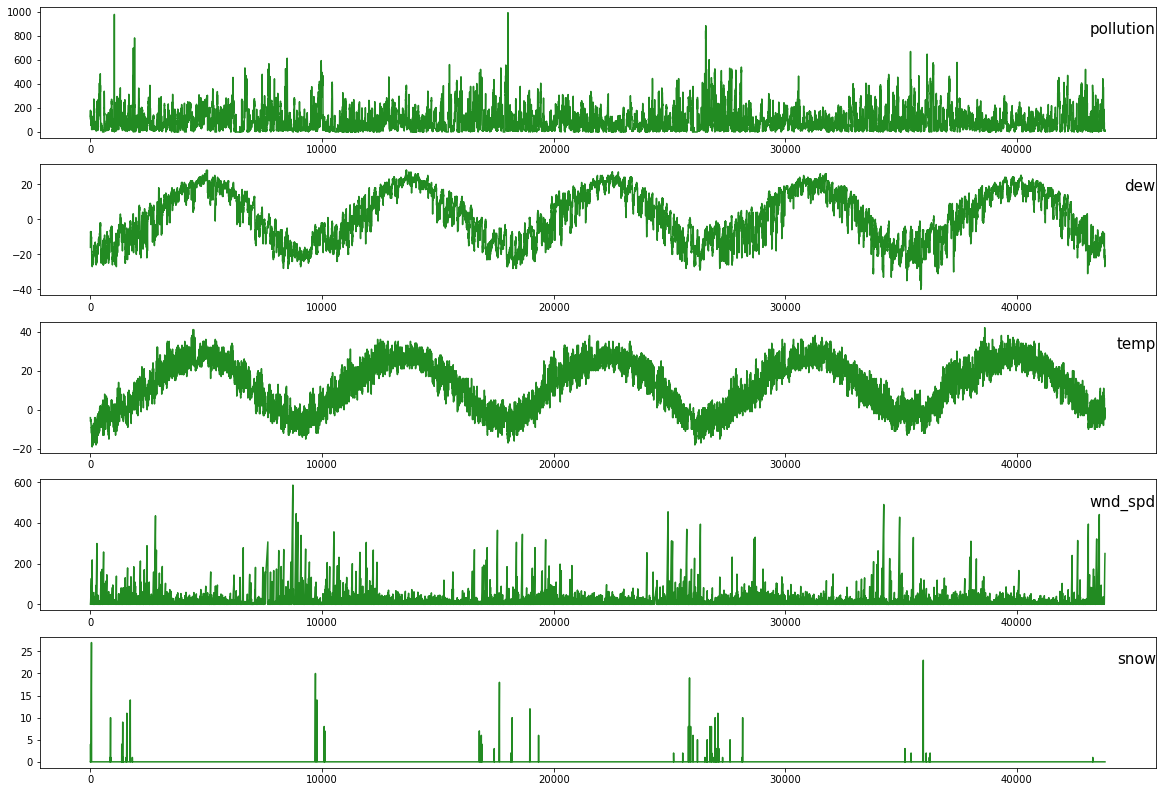

In [17]:
values = df.values

# specify columns to plot
groups = [1, 2, 3, 5, 6]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "forestgreen")
    plt.title(df.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

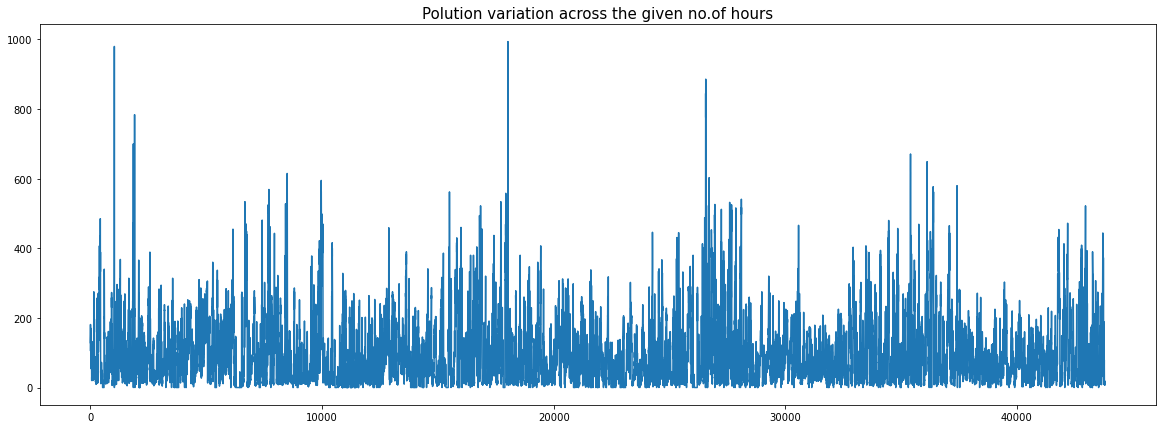

In [18]:
fig = plt.figure(figsize = (20,7))
plt.plot(df.pollution)
plt.title("Polution variation across the given no.of hours", fontsize = 15)
plt.show()

In [19]:
del df["date"]

In [20]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [21]:
df

,pollution,dew,temp,press,wnd_spd,snow,rain,wind_dir
0,129.0,-16,-4.0,1020.0,1.79,0,0,1
1,148.0,-15,-4.0,1020.0,2.68,0,0,1
2,159.0,-11,-5.0,1021.0,3.57,0,0,1
3,181.0,-7,-5.0,1022.0,5.36,1,0,1
4,138.0,-7,-5.0,1022.0,6.25,2,0,1
...,...,...,...,...,...,...,...,...
43795,8.0,-23,-2.0,1034.0,231.97,0,0,3
43796,10.0,-22,-3.0,1034.0,237.78,0,0,3
43797,10.0,-22,-3.0,1034.0,242.70,0,0,3
43798,8.0,-22,-4.0,1034.0,246.72,0,0,3


In [22]:
dataset = df
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [23]:
n_hours = 24
n_features = 14


# converting the dataset as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

(43799, 16)


In [24]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.002290   0.000000   
2   0.148893   0.367647   0.245902   0.527273   0.003811   0.000000   
3   0.159960   0.426471   0.229508   0.545454   0.005332   0.000000   
4   0.182093   0.485294   0.229508   0.563637   0.008391   0.037037   
5   0.138833   0.485294   0.229508   0.563637   0.009912   0.074074   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1        0.0        0.0  0.148893  0.367647  0.245902  0.527273  0.003811   
2        0.0        0.0  0.159960  0.426471  0.229508  0.545454  0.005332   
3        0.0        0.0  0.182093  0.485294  0.229508  0.563637  0.008391   
4        0.0        0.0  0.138833  0.485294  0.229508  0.563637  0.009912   
5        0.0        0.0  0.109658  0.485294  0.213115  0.563637  0.011433   

    var6(t)  var7(t)  var8(t)  
1  0.000000      0.0      0.0  
2  0.000000      0.0      0.0  
3  0.037037   

In [25]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var1(t)', 'var2(t)', 'var3(t)',
       'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)'],
      dtype='object')

In [26]:
# droping columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.002290   0.000000   
2   0.148893   0.367647   0.245902   0.527273   0.003811   0.000000   
3   0.159960   0.426471   0.229508   0.545454   0.005332   0.000000   
4   0.182093   0.485294   0.229508   0.563637   0.008391   0.037037   
5   0.138833   0.485294   0.229508   0.563637   0.009912   0.074074   

   var7(t-1)  var8(t-1)   var1(t)  
1        0.0        0.0  0.148893  
2        0.0        0.0  0.159960  
3        0.0        0.0  0.182093  
4        0.0        0.0  0.138833  
5        0.0        0.0  0.109658  


In [27]:
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = 365 * 24 * 3

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 8) (26280,) (17519, 1, 8) (17519,)


In [28]:
train.shape, test.shape, values.shape

((26280, 9), (17519, 9), (43799, 9))

### Creating and testing on a basic model 

In [29]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [30]:
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
292/292 - 4s - loss: 0.0047 - val_loss: 0.0035 - 4s/epoch - 13ms/step
Epoch 2/50
292/292 - 1s - loss: 0.0016 - val_loss: 0.0018 - 925ms/epoch - 3ms/step
Epoch 3/50
292/292 - 1s - loss: 0.0011 - val_loss: 0.0010 - 894ms/epoch - 3ms/step
Epoch 4/50
292/292 - 1s - loss: 9.2819e-04 - val_loss: 7.8874e-04 - 910ms/epoch - 3ms/step
Epoch 5/50
292/292 - 1s - loss: 8.7758e-04 - val_loss: 6.9943e-04 - 920ms/epoch - 3ms/step
Epoch 6/50
292/292 - 1s - loss: 8.5940e-04 - val_loss: 6.6062e-04 - 934ms/epoch - 3ms/step
Epoch 7/50
292/292 - 1s - loss: 8.5141e-04 - val_loss: 6.3839e-04 - 926ms/epoch - 3ms/step
Epoch 8/50
292/292 - 1s - loss: 8.4602e-04 - val_loss: 6.2102e-04 - 909ms/epoch - 3ms/step
Epoch 9/50
292/292 - 1s - loss: 8.4203e-04 - val_loss: 6.0631e-04 - 910ms/epoch - 3ms/step
Epoch 10/50
292/292 - 1s - loss: 8.3981e-04 - val_loss: 5.9549e-04 - 910ms/epoch - 3ms/step
Epoch 11/50
292/292 - 1s - loss: 8.3901e-04 - val_loss: 5.8784e-04 - 926ms/epoch - 3ms/step
Epoch 12/50
292/292 - 1

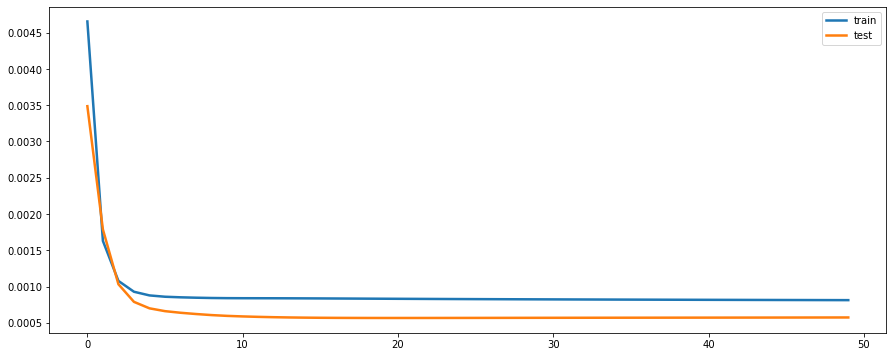

In [31]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [32]:
test_X.shape,

((17519, 1, 8),)

In [33]:
testPredict = model.predict(test_X)
print(testPredict.shape)
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# testPredict = scaler.inverse_transform(testPredict).ravel()
testPredict = testPredict.ravel()

print(testPredict.shape)

(17519, 1)
(17519,)


In [34]:
test.shape

(17519, 9)

In [35]:
print(test), print(test.shape)

[[0.03521127 0.44117647 0.22950819 ... 0.         0.6666666  0.03118712]
 [0.03118712 0.4264706  0.1967213  ... 0.         0.6666666  0.03219316]
 [0.03219316 0.4264706  0.1967213  ... 0.         0.6666666  0.02112676]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.         0.6666666  0.01006036]
 [0.01006036 0.2647059  0.26229507 ... 0.         0.6666666  0.00804829]
 [0.00804829 0.2647059  0.24590163 ... 0.         0.6666666  0.01207243]]
(17519, 9)


(None, None)

In [36]:
y_test_true = test[:,8]

In [37]:
poll = np.array(df["pollution"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

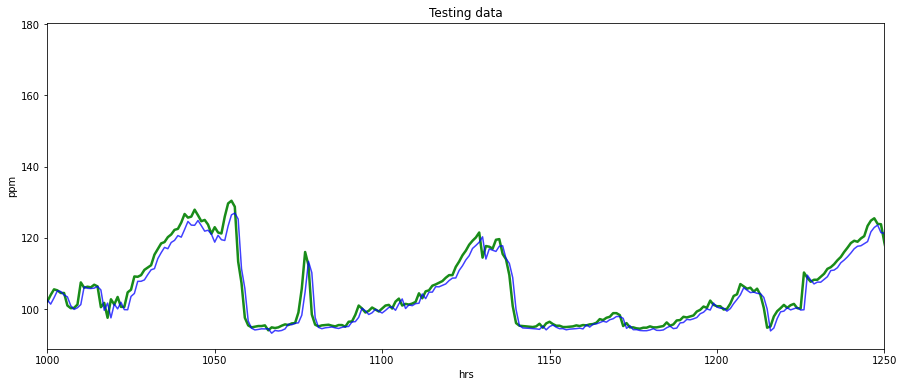

In [38]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [39]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))
print("Test RMSE ="  ,rmse)

# As we see the,  RMSE for testing data is low, and visually as well, from the above plots, we can see that the basic model is able to
# predict the future values of pollution (in ppm) pretty well

Test RMSE = 2.5849519


In [40]:
model2 = Sequential()
model2.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dense(64))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Dense(1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               271360    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 288,129
Trainable params: 288,001
Non-trainable params: 128
______________________________________________

In [41]:
model2.compile(loss='mse', optimizer='adam')

hist2 = model2.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y))

Epoch 1/50
206/206 [==============================] - 9s 23ms/step - loss: 0.0110 - val_loss: 0.0078
Epoch 2/50
206/206 [==============================] - 3s 17ms/step - loss: 0.0016 - val_loss: 0.0057
Epoch 3/50
206/206 [==============================] - 3s 13ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 4/50
206/206 [==============================] - 3s 12ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/50
206/206 [==============================] - 3s 13ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 6/50
206/206 [==============================] - 3s 12ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/50
206/206 [==============================] - 3s 12ms/step - loss: 0.0014 - val_loss: 7.7533e-04
Epoch 8/50
206/206 [==============================] - 3s 12ms/step - loss: 0.0013 - val_loss: 8.6481e-04
Epoch 9/50
206/206 [==============================] - 3s 12ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/50
206/206 [==============================] - 3s 12ms/step - loss: 0.0012 

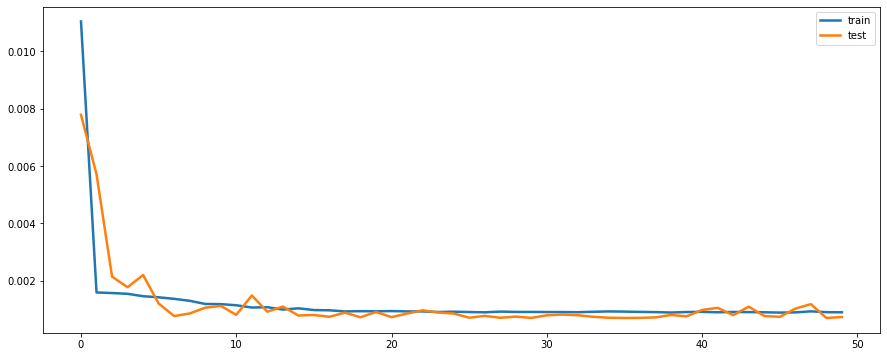

In [42]:
plt.figure(figsize=(15,6))
plt.plot(hist2.history['loss'], label='train', linewidth = 2.5)
plt.plot(hist2.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [43]:
y_test_true = test[:,8]

In [44]:
testPredict2 = model2.predict(test_X)
testPredict2 = testPredict2.ravel()

poll = np.array(df["pollution"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_test_true = y_test_true*stdop + meanop
testPredict2 = testPredict2*stdop + meanop

94.01351598173515 92.25122315439845


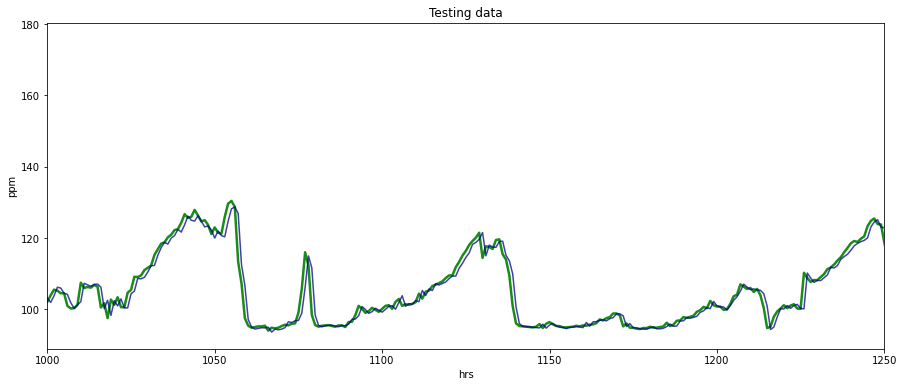

In [45]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict2, c = "darkblue", alpha = 0.75)
plt.title("Testing data")
plt.show()

In [46]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict2))
print("Test RMSE ="  ,rmse)

Test RMSE = 2.510259


## Training on the complete training dataset 

In [47]:
values.shape

(43799, 9)

In [48]:
values

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.        , 0.        ,
        0.14889336],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.        , 0.        ,
        0.15995975],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.        , 0.        ,
        0.18209255],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.        , 0.6666666 ,
        0.01006036],
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.        , 0.6666666 ,
        0.00804829],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.        , 0.6666666 ,
        0.01207243]], dtype=float32)

In [49]:
train_x, train_y = values[:, :-1], values[:, -1]
print(train_x.shape, train_y.shape)

(43799, 8) (43799,)


In [50]:
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))

In [51]:
model3 = Sequential()
model3.add(LSTM(256, input_shape=(train_x.shape[1], train_x.shape[2])))
model3.add(Dense(32))
model3.add(Dropout(0.45))
model3.add(BatchNormalization())
model3.add(Dense(1))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               271360    
                                                                 
 dense_3 (Dense)             (None, 32)                8224      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 279,745
Trainable params: 279,681
Non-trainable params: 64
_______________________________________________

In [52]:
model3.compile(loss='mse', optimizer='adam')

hist3 = model3.fit(train_x, train_y, epochs=50, batch_size=256, validation_split=0.2)

Epoch 1/50
137/137 [==============================] - 4s 20ms/step - loss: 0.0270 - val_loss: 0.0079
Epoch 2/50
137/137 [==============================] - 2s 17ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 3/50
137/137 [==============================] - 2s 16ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 4/50
137/137 [==============================] - 2s 16ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 5/50
137/137 [==============================] - 2s 17ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/50
137/137 [==============================] - 3s 19ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/50
137/137 [==============================] - 3s 21ms/step - loss: 0.0015 - val_loss: 8.4452e-04
Epoch 8/50
137/137 [==============================] - 3s 22ms/step - loss: 0.0017 - val_loss: 6.9112e-04
Epoch 9/50
137/137 [==============================] - 2s 16ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 10/50
137/137 [==============================] - 2s 16ms/step - loss: 0.0017 

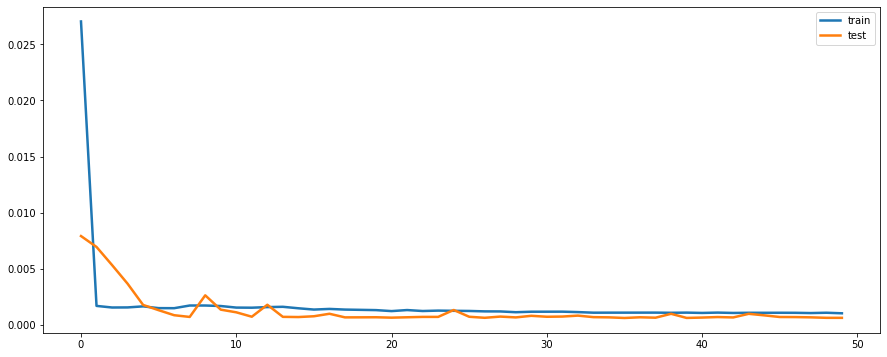

In [53]:
plt.figure(figsize=(15,6))
plt.plot(hist3.history['loss'], label='train', linewidth = 2.5)
plt.plot(hist3.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [54]:
y_train_true = values[:,8]

In [55]:
# y_train_true

In [56]:
trainPredict3 = model3.predict(train_x)
trainPredict3 = trainPredict3.ravel()


poll = np.array(df["pollution"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_train_true = y_train_true*stdop + meanop
trainPredict3 = trainPredict3*stdop + meanop

94.01351598173515 92.25122315439845


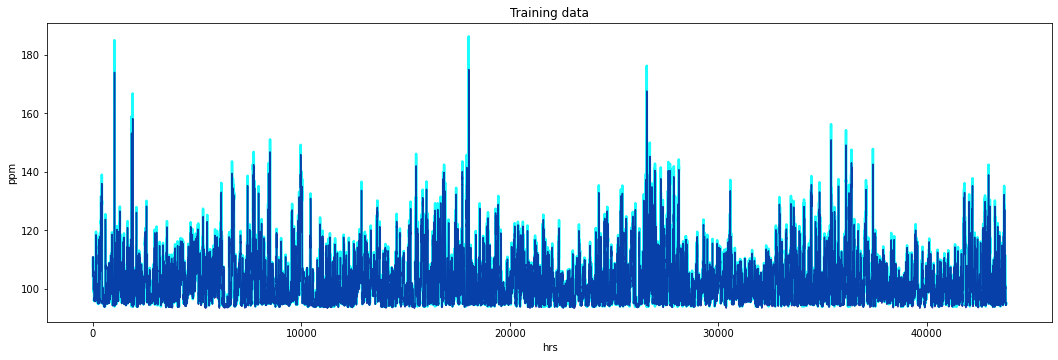

In [57]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
# plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_train_true, c = "cyan", alpha = 0.90, linewidth = 2.5)
plt.plot(trainPredict3, c = "darkblue", alpha = 0.75)
plt.title("Training data")
plt.show()

# darkblue

In [58]:
rmse = np.sqrt(mean_squared_error(y_train_true, trainPredict3))
print("Train RMSE ="  ,rmse)

Train RMSE = 2.5194306


In [59]:
test_df = pd.read_csv("C:\\Users\\srevaatsav\\Downloads\\air pollution data\\pollution_test_data1.csv")
test_df

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93
...,...,...,...,...,...,...,...,...
341,-23,-2,1034,NW,231.97,0,0,8
342,-22,-3,1034,NW,237.78,0,0,10
343,-22,-3,1034,NW,242.70,0,0,10
344,-22,-4,1034,NW,246.72,0,0,8


In [60]:
test_df["wind_dir"] = test_df["wnd_dir"].apply(func)
del test_df["wnd_dir"]

In [61]:
values_test = test_df.values
values_test = values_test.astype('float32')

In [62]:
scaler1 = MinMaxScaler()
scaled_test = scaler1.fit_transform(values_test)
reframed_test = series_to_supervised(scaled_test, 1, 1)

In [63]:
reframed_test

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.523809,0.65,0.666668,0.007102,0.0,0.0,0.288288,0.000000,0.476190,0.70,0.666668,0.016223,0.0,0.0,0.173423,0.000000
2,0.476190,0.70,0.666668,0.016223,0.0,0.0,0.173423,0.000000,0.523809,0.65,0.666668,0.020285,0.0,0.0,0.146396,0.000000
3,0.523809,0.65,0.666668,0.020285,0.0,0.0,0.146396,0.000000,0.523809,0.50,0.708336,0.000998,0.0,0.0,0.177928,1.000000
4,0.523809,0.50,0.708336,0.000998,0.0,0.0,0.177928,1.000000,0.619048,0.45,0.708336,0.003040,0.0,0.0,0.209459,0.333333
5,0.619048,0.45,0.708336,0.003040,0.0,0.0,0.209459,0.333333,0.571429,0.35,0.750000,0.007102,0.0,0.0,0.234234,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,0.238095,0.35,0.916668,0.512128,0.0,0.0,0.022523,0.666667,0.190476,0.35,0.958336,0.525310,0.0,0.0,0.018018,0.666667
342,0.190476,0.35,0.958336,0.525310,0.0,0.0,0.018018,0.666667,0.238095,0.30,0.958336,0.538493,0.0,0.0,0.022523,0.666667
343,0.238095,0.30,0.958336,0.538493,0.0,0.0,0.022523,0.666667,0.238095,0.30,0.958336,0.549656,0.0,0.0,0.022523,0.666667
344,0.238095,0.30,0.958336,0.549656,0.0,0.0,0.022523,0.666667,0.238095,0.25,0.958336,0.558778,0.0,0.0,0.018018,0.666667


In [64]:
reframed_test.drop(reframed_test.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed_test.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.523809       0.65   0.666668   0.007102        0.0        0.0   
2   0.476190       0.70   0.666668   0.016223        0.0        0.0   
3   0.523809       0.65   0.666668   0.020285        0.0        0.0   
4   0.523809       0.50   0.708336   0.000998        0.0        0.0   
5   0.619048       0.45   0.708336   0.003040        0.0        0.0   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.288288   0.000000  0.476190  
2   0.173423   0.000000  0.523809  
3   0.146396   0.000000  0.523809  
4   0.177928   1.000000  0.619048  
5   0.209459   0.333333  0.571429  


In [65]:
values_test1 = reframed_test.values

test_x, test_y = values_test1[:, :-1], values_test1[:, -1]

# reshape input to be 3D [samples, timesteps, features]
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [66]:
test_x.shape, test_y.shape

((345, 1, 8), (345,))

In [68]:
testPredict3 = model3.predict(test_x)
testPredict3 = testPredict3.ravel()
poll = np.array(df["pollution"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

test_y = test_y*stdop + meanop
testPredict3 = testPredict3*stdop + meanop

94.01351598173515 92.25122315439845


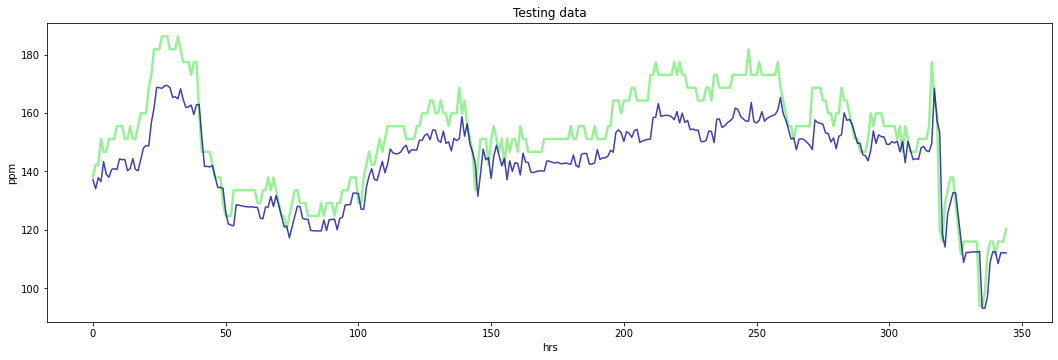

In [72]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(test_y, c = "lightgreen", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict3, c = "darkblue", alpha = 0.75)
plt.title("Testing data")
plt.show()
# darkblue

In [73]:
rmse = np.sqrt(mean_squared_error(test_y, testPredict3))
print("Test RMSE ="  ,rmse)

Test RMSE = 10.273226
